In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'mps'
print(device)

mps


# data transform --> norm, type casting, crop, rotation

In [3]:
train_transform = transforms.Compose([
    transforms.ToTensor(), # 0~1 numpy -> tensor,
    # 0 ~ 1 0-0.5/0.5:-1 (1-0.5)/0.5, -1~1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # 좌우 반전
    transforms.RandomHorizontalFlip(p=0.5), 
])

test_transform = transforms.Compose([
    transforms.ToTensor(), # 0~1 numpy -> tensor,
    # 0 ~ 1 0-0.5/0.5:-1 (1-0.5)/0.5, -1~1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainset.data.shape, len(trainset.targets), trainset.targets[:10]

((50000, 32, 32, 3), 50000, [6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [8]:
images, labels = next(iter(trainloader))

In [9]:
images.shape, labels.shape, images.min(), images.max()

(torch.Size([100, 3, 32, 32]), torch.Size([100]), tensor(-1.), tensor(1.))

In [10]:
import matplotlib.pyplot as plt

In [ ]:
images[0].permute(1,2,0).shape

In [ ]:
img = images[1].permute(1,2,0)

In [ ]:
img = img * 0.5 + 0.5

In [ ]:
img.min(), img.max()

In [ ]:
plt.title(classes[labels[1].item()])
plt.imshow(img)
plt.show()

# model init 

In [ ]:
# output = input-kernel+(2*padding) / stride + 1
# output = 32 - 3 + (2) / 1 + 1
class AlexNet(nn.Module) :
    def __init__(self) :
        super(AlexNet, self).__init__()
        self.name = "AlexNet"
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=(4, 4)),
            nn.ReLU(inplace=True),
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=(5, 5), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.fc_layer1 = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(9216, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10)
        )

    def forward(self, x) :
        output = self.conv_layer1(x)
        output = self.conv_layer2(output)
        output = self.conv_layer3(output)
        output = output.view(-1, 9216)
        output = self.fc_layer1(output)
        return output

In [11]:
class cifar_cnn(nn.Module):
    def __init__(self):
        super(cifar_cnn, self).__init__()
        # layer
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3,3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(3,3)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # 32 x 5 x 5
        
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(0.5), 
            nn.Linear(32*5*5, 64),
            nn.ReLU(inplace=True),
            
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            
            nn.Linear(32, 10)

        )
        
    
    def forward(self, x):
        # 순전파
        
        out = self.conv_layer(x)
        # bx16x5x5 --> 1d --> 400
        out = out.view(out.shape[0], -1)
        
        out = self.fc_layer(out)
        
        
        return out
        
    

In [12]:
model = cifar_cnn()

from torchsummary import summary

summary(model, input_size=((3, 32, 32)))

# model learning 

In [15]:
learning_rate = 0.001 #1e-2

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
epochs = 10
model = model.to(device)
for _epoch in range(epochs):
    for it_batch, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        
        if (it_batch+1) % 30 == 0:
            print(f'epoch:{_epoch}, batch:{it_batch}, loss{loss.item()}')
            
            with torch.no_grad():
                model.eval()

                correct_ = 0
                total_ = 0

                for it_batch, (images, labels) in enumerate(testloader):
                    images = images.to(device)
                    labels = labels.to(device)                    
                    
                    outputs = model(images)

                    predcits = torch.argmax(outputs, axis=1)
                    correct_ += (labels == predcits).sum()
                    total_ += predcits.shape[0]

                acc = correct_/total_ * 100
                print(f'acc{acc:.2f}, correct{correct_}, total{total_}')
                
                model.train()


epoch:0, batch:29, loss2.208397150039673
acc20.42, correct2042, total10000
epoch:0, batch:59, loss2.2355751991271973
acc23.93, correct2393, total10000
epoch:0, batch:89, loss2.020076274871826
acc24.18, correct2418, total10000
epoch:0, batch:119, loss1.974476933479309
acc29.83, correct2983, total10000
epoch:0, batch:149, loss1.9210091829299927
acc32.06, correct3206, total10000
epoch:0, batch:179, loss1.7885204553604126
acc35.15, correct3515, total10000
epoch:0, batch:209, loss1.8393332958221436
acc36.25, correct3625, total10000
epoch:0, batch:239, loss1.9569189548492432
acc37.25, correct3725, total10000
epoch:0, batch:269, loss1.7832920551300049
acc36.31, correct3631, total10000
epoch:0, batch:299, loss1.6075983047485352
acc37.22, correct3722, total10000
epoch:0, batch:329, loss1.5614498853683472
acc38.95, correct3895, total10000
epoch:0, batch:359, loss1.6528754234313965
acc38.38, correct3838, total10000
epoch:0, batch:389, loss1.775351881980896
acc38.83, correct3883, total10000
epoch:

acc62.65, correct6265, total10000
epoch:6, batch:389, loss1.0903706550598145
acc61.38, correct6138, total10000
epoch:6, batch:419, loss1.1838164329528809
acc61.63, correct6163, total10000
epoch:6, batch:449, loss1.0865522623062134
acc62.68, correct6268, total10000
epoch:6, batch:479, loss1.1001839637756348
acc61.80, correct6180, total10000
epoch:7, batch:29, loss1.0789283514022827
acc62.32, correct6232, total10000
epoch:7, batch:59, loss1.2218598127365112
acc62.63, correct6263, total10000
epoch:7, batch:89, loss1.1021565198898315
acc61.73, correct6173, total10000
epoch:7, batch:119, loss1.0764236450195312
acc61.81, correct6181, total10000
epoch:7, batch:149, loss1.1860641241073608
acc61.05, correct6105, total10000
epoch:7, batch:179, loss1.1118907928466797
acc62.02, correct6202, total10000
epoch:7, batch:209, loss1.1777756214141846
acc62.35, correct6235, total10000
epoch:7, batch:239, loss1.2448437213897705
acc63.04, correct6304, total10000
epoch:7, batch:269, loss1.1350123882293701
ac

# evaluate  

In [17]:
model = model.to('cpu')

In [18]:

with torch.no_grad():
    model.eval()
    
    correct_ = 0
    total_ = 0

    for it_batch, (images, labels) in enumerate(testloader):
        
        outputs = model(images)
        
        predcits = torch.argmax(outputs, axis=1)
        correct_ += (labels == predcits).sum()
        total_ += predcits.shape[0]
    
    acc = correct_/total_ * 100
    print(f'acc{acc:.2f}, correct{correct_}, total{total_}')
    

acc63.20, correct6320, total10000


# Display results

In [19]:
def display_torch_result(images, labels, predicts):
    
    for img, lab, pred in zip(images, labels, predicts):
        img = img.permute(1, 2, 0)
        img = img * 0.5 + 0.5
        target = classes[lab.item()]
        pred_cls = classes[pred.item()]
        
#         if target != pred_cls:
        _title = f'gt[{target}],p[{pred_cls}]'
        plt.title(_title)
        plt.imshow(img)
        plt.show()
        


In [20]:
iter_test = iter(testloader)


In [30]:
images, labels = next(iter_test)

outputs= model(images)

predicts = torch.argmax(outputs, axis=1)

(labels == predicts).sum()

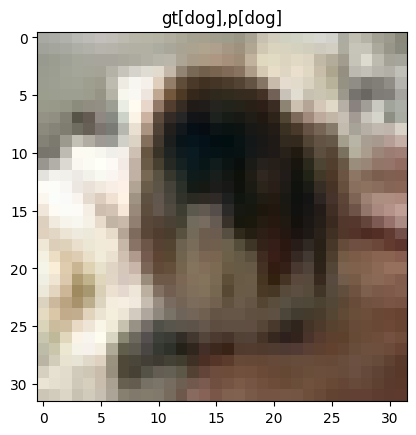

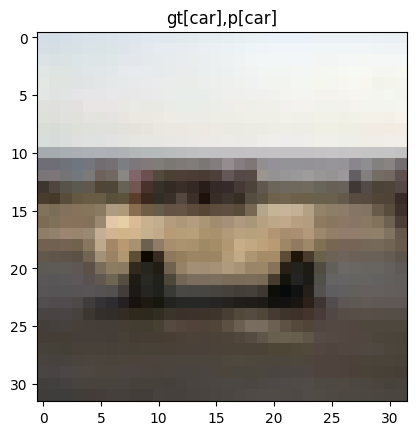

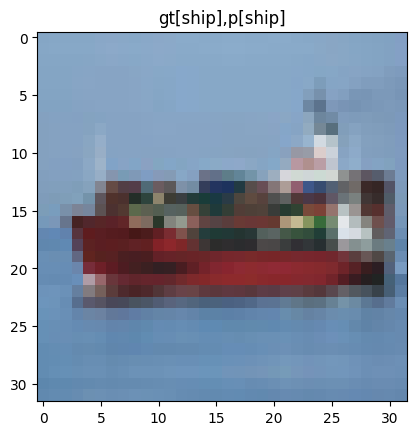

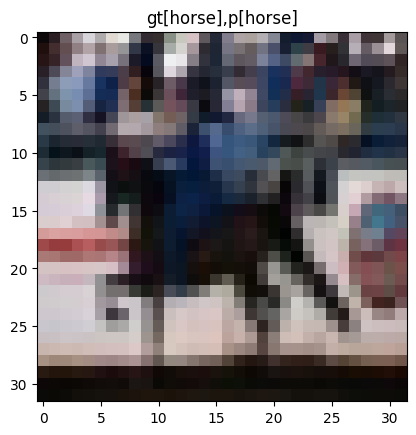

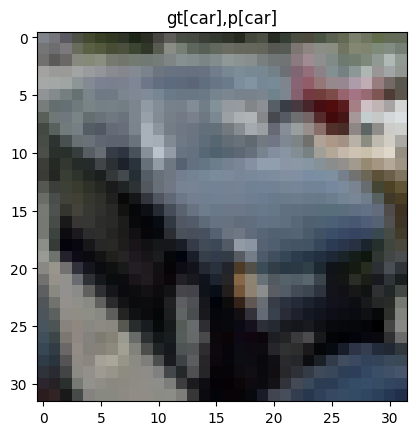

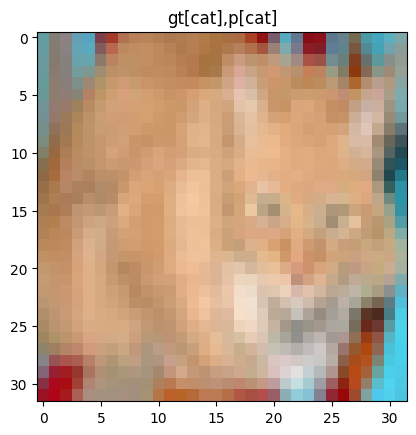

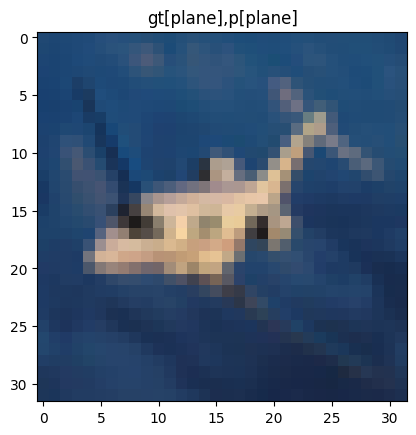

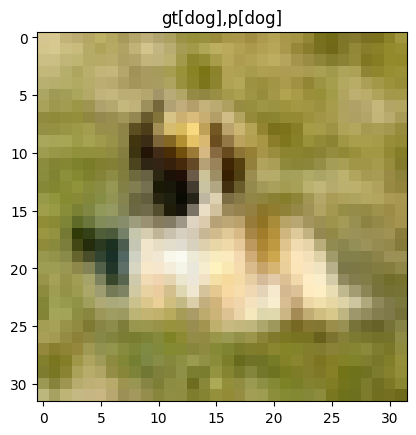

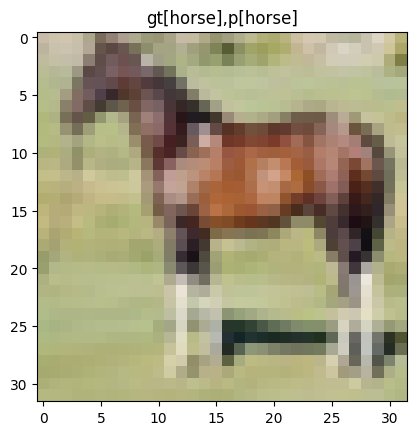

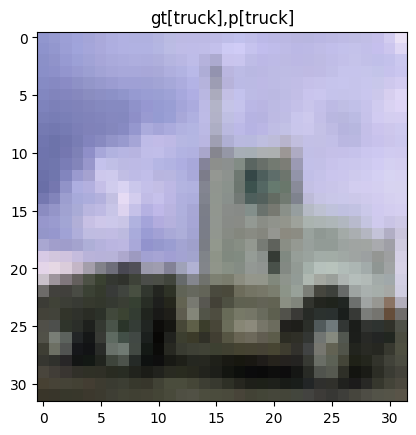

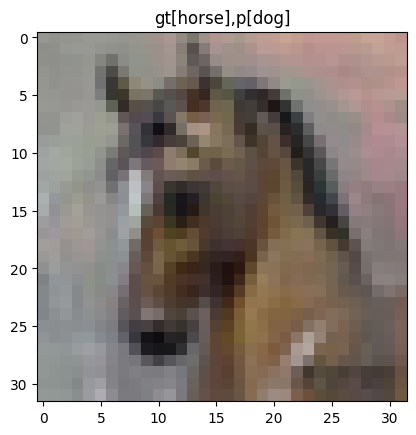

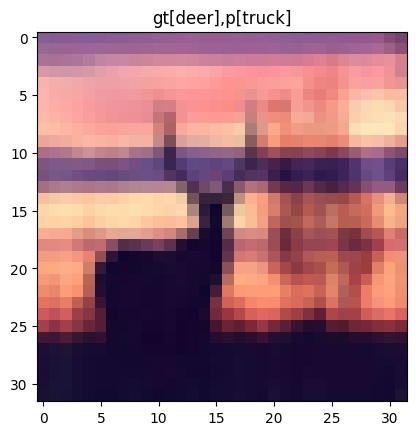

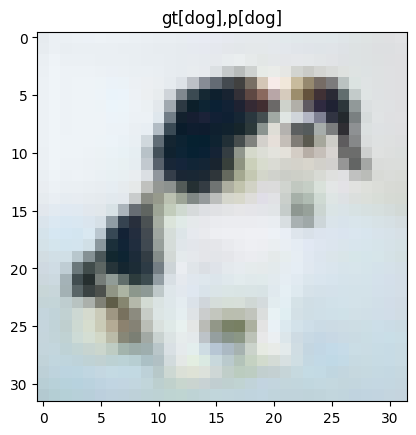

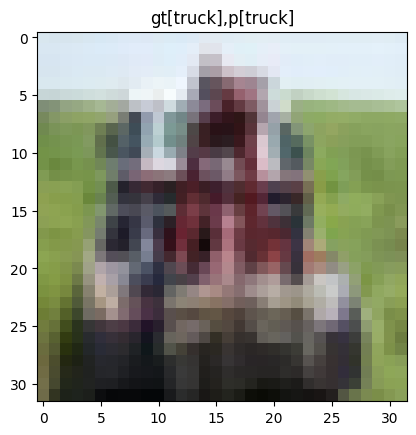

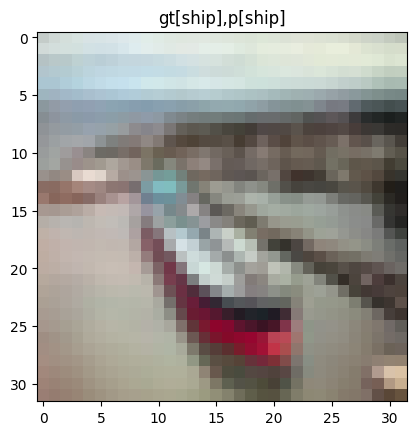

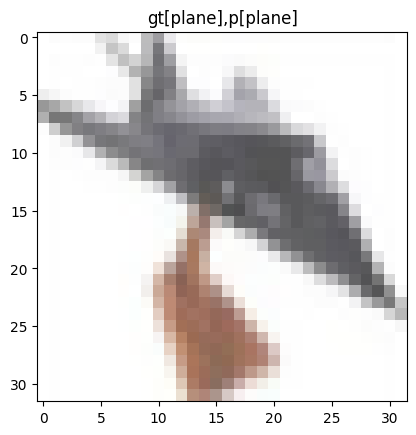

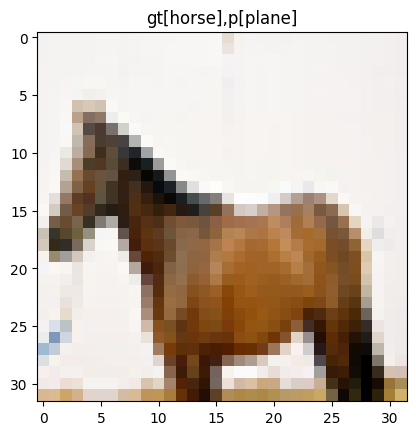

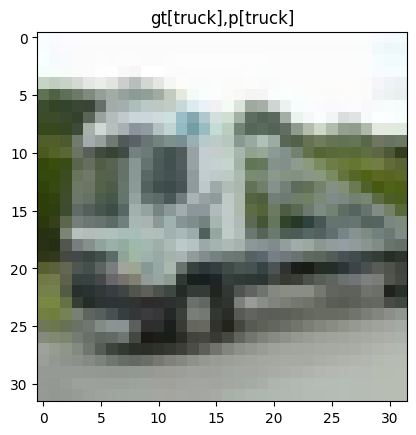

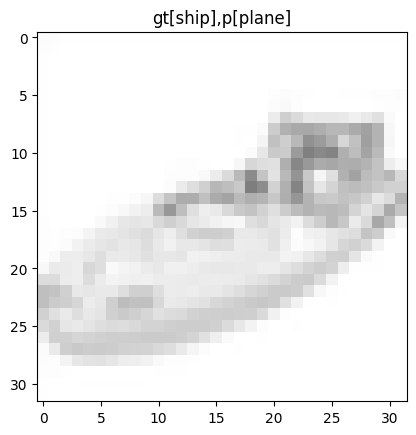

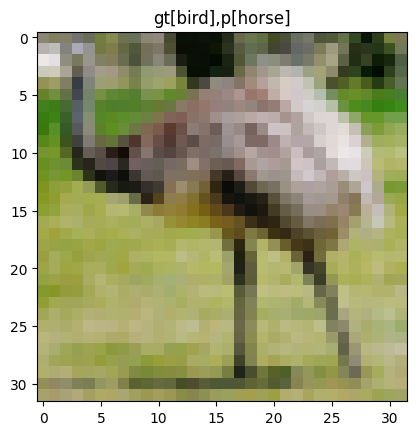

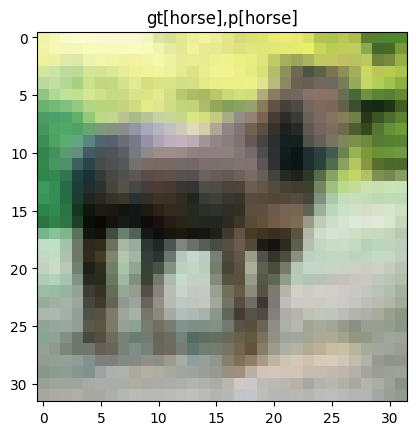

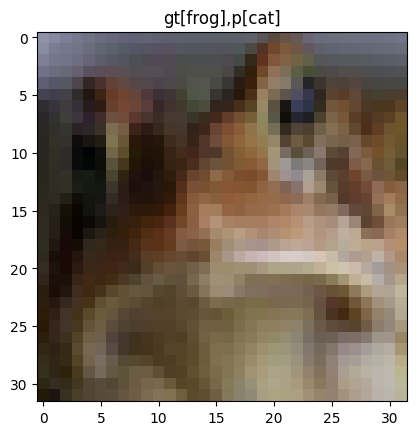

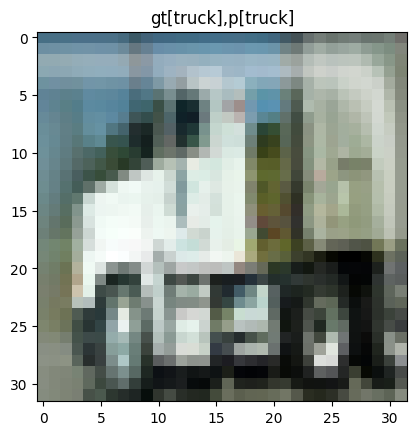

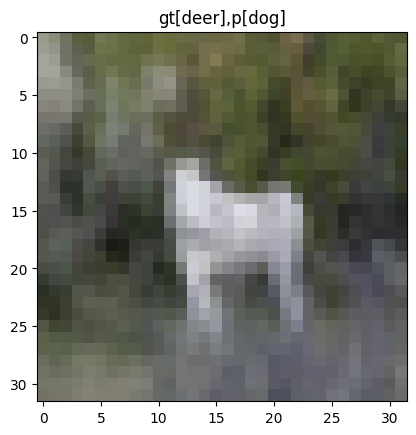

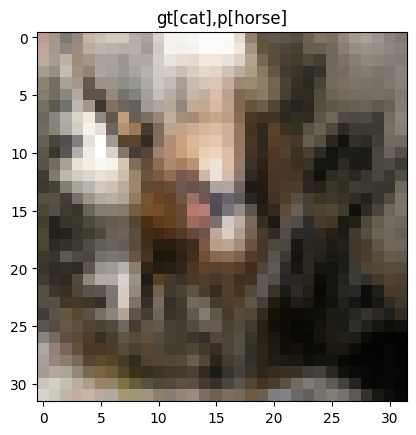

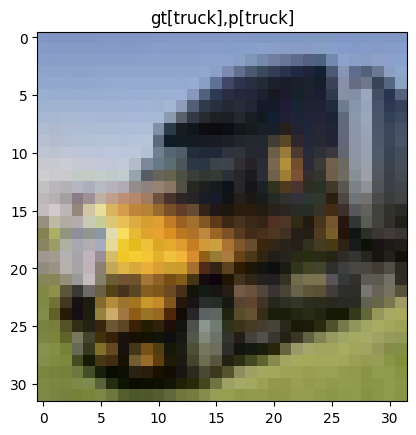

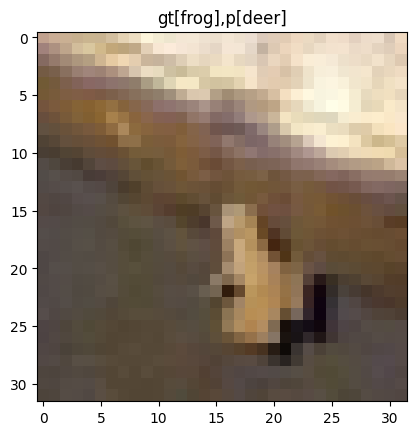

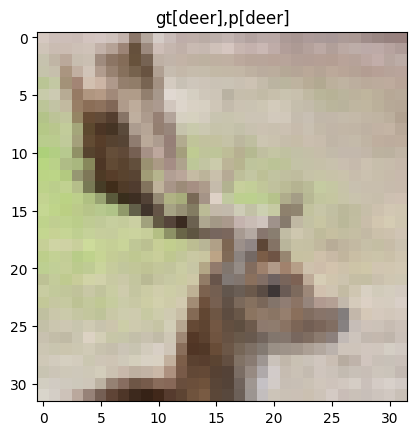

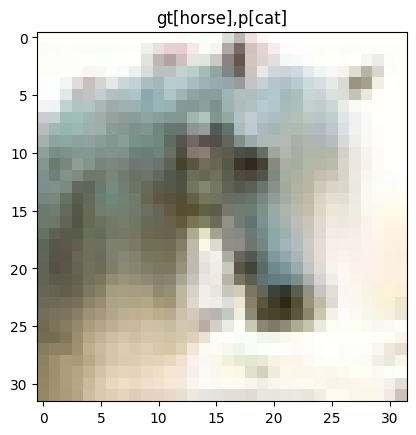

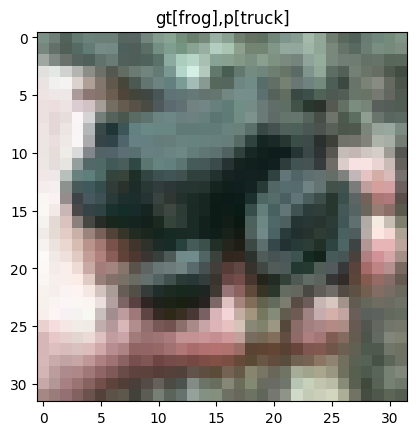

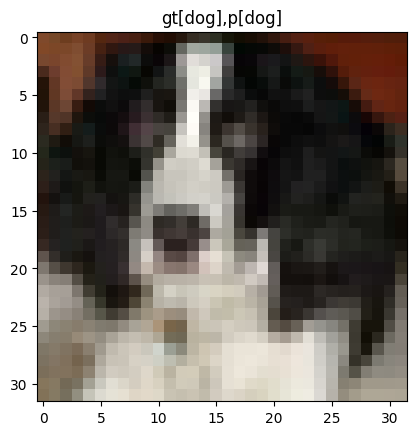

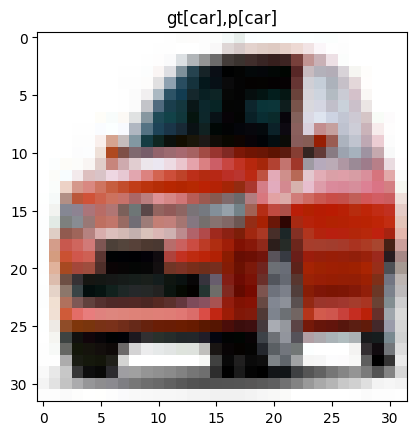

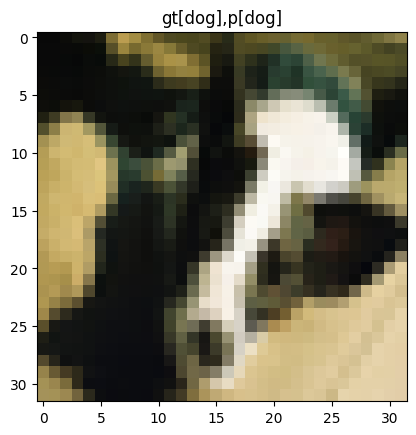

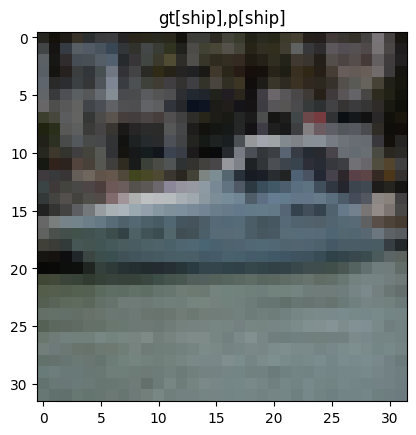

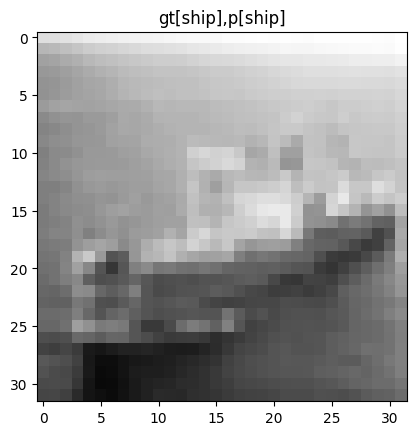

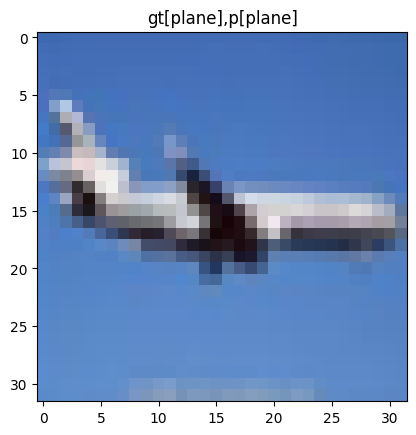

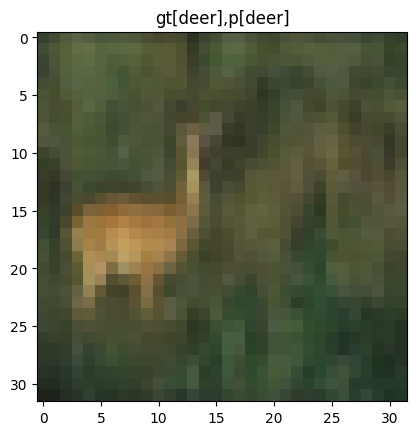

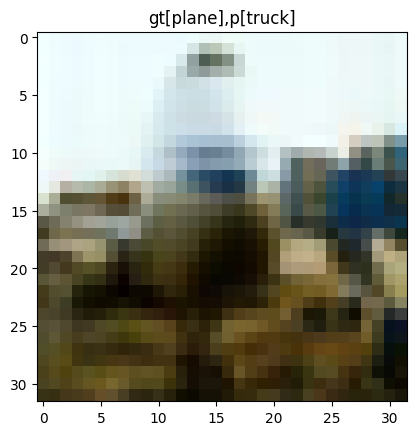

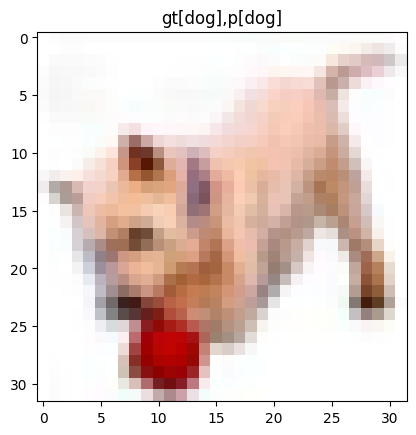

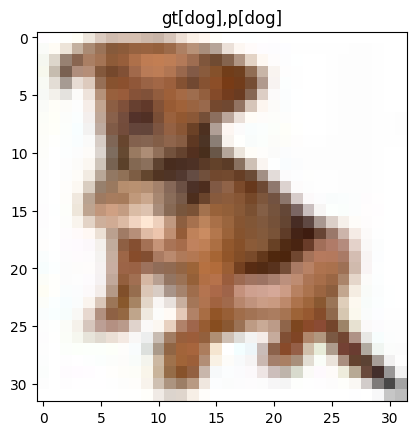

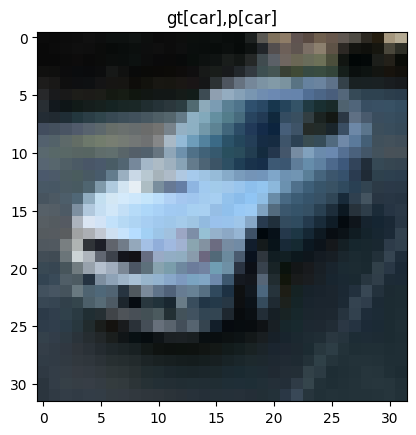

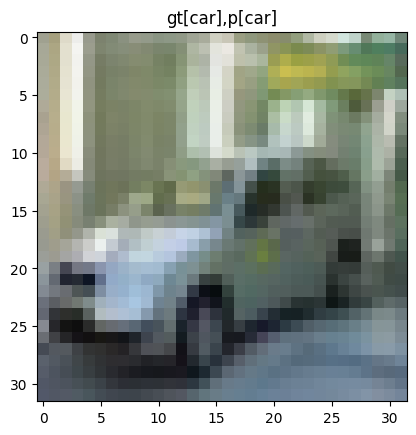

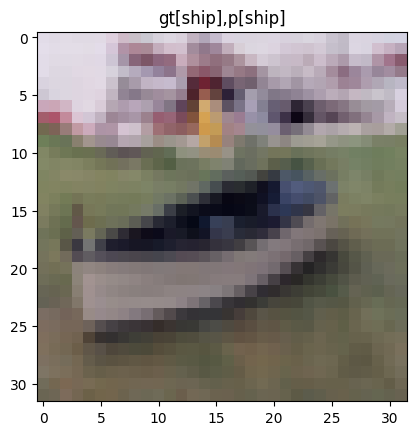

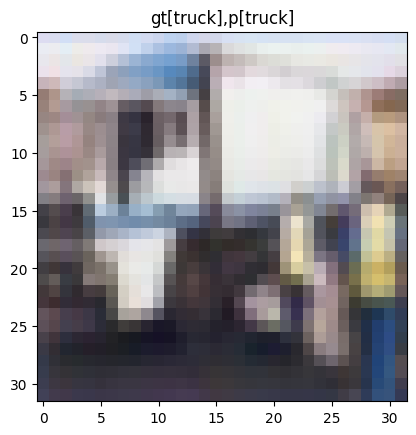

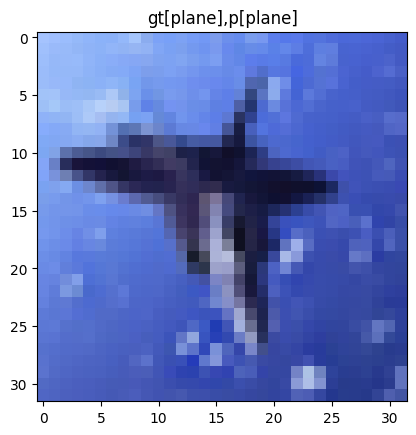

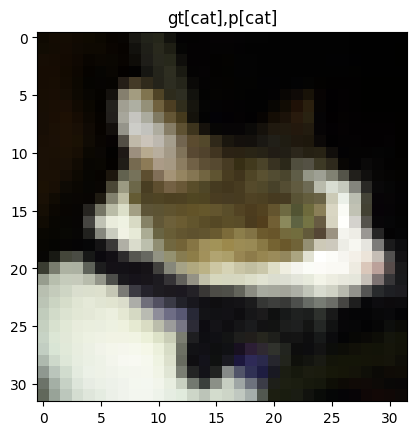

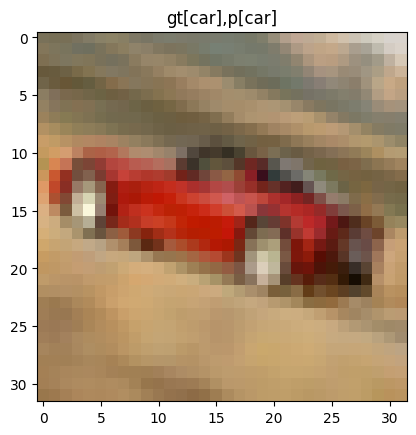

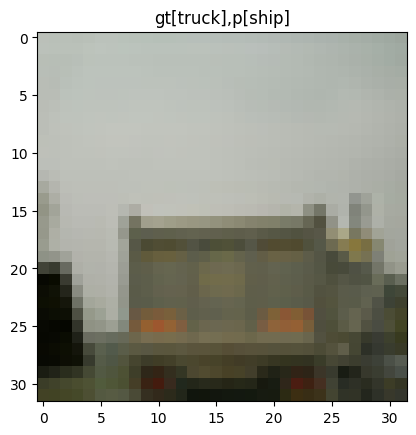

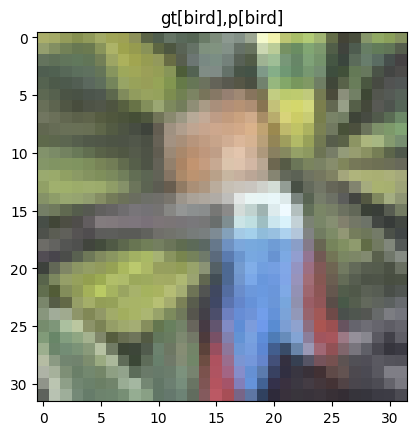

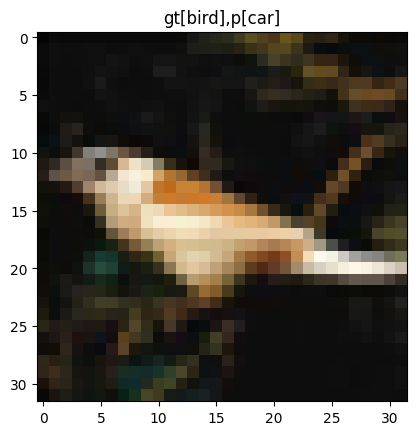

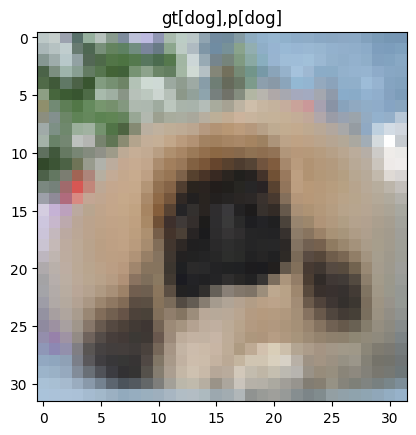

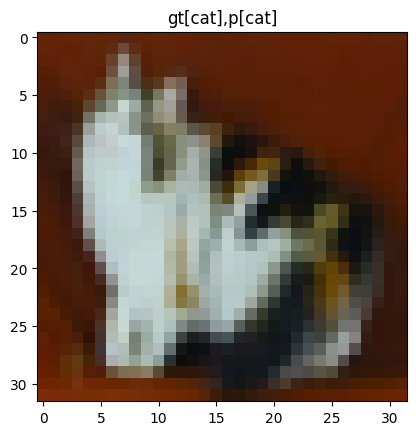

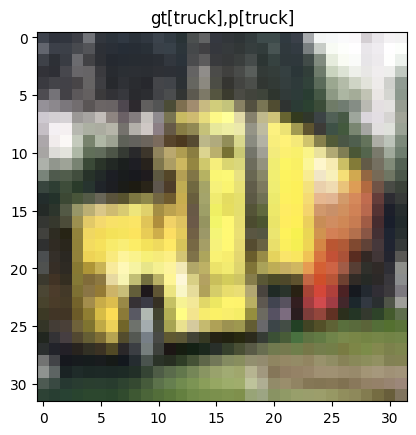

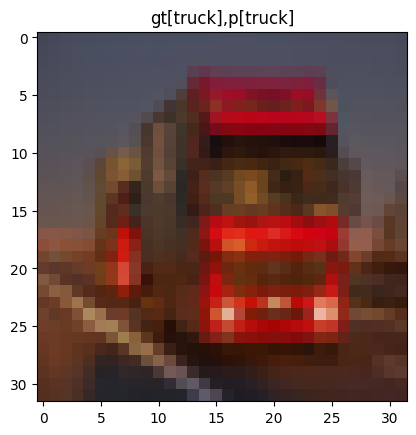

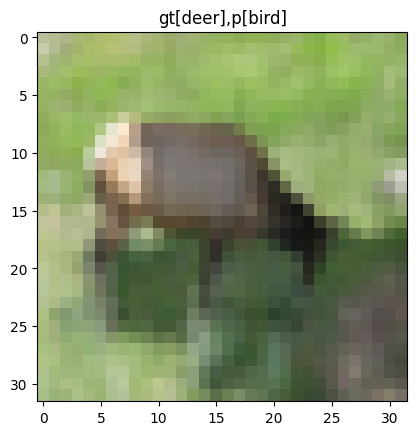

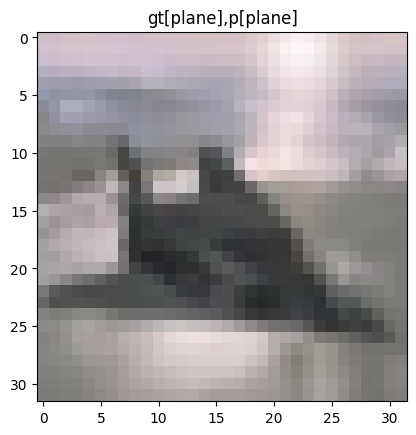

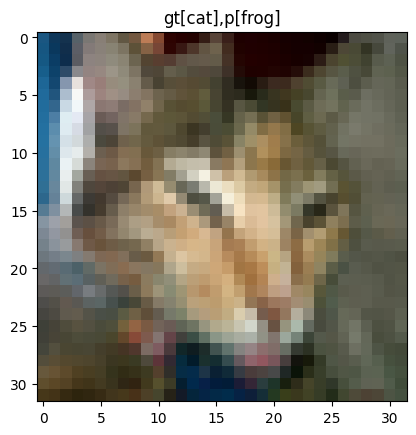

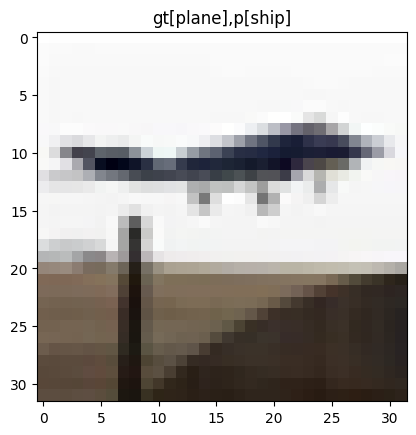

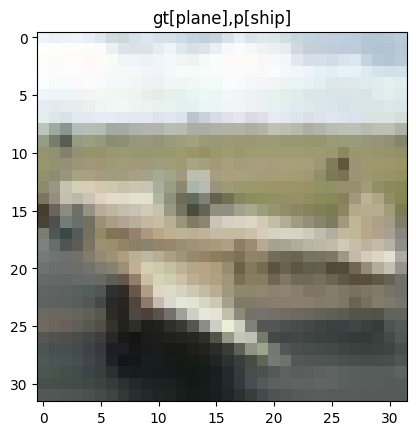

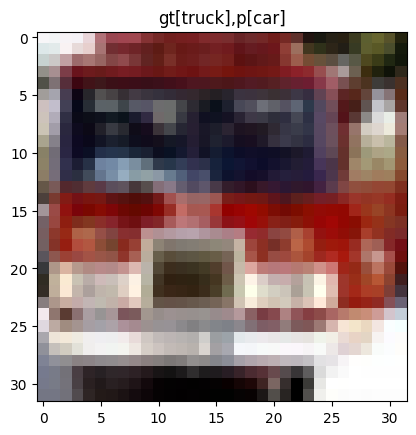

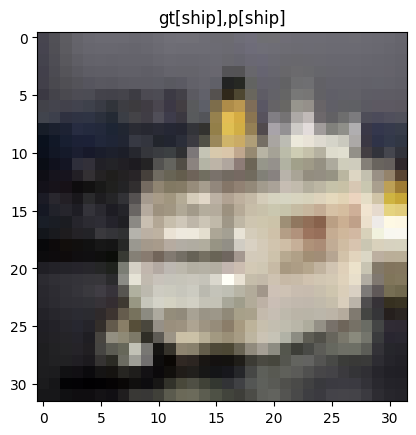

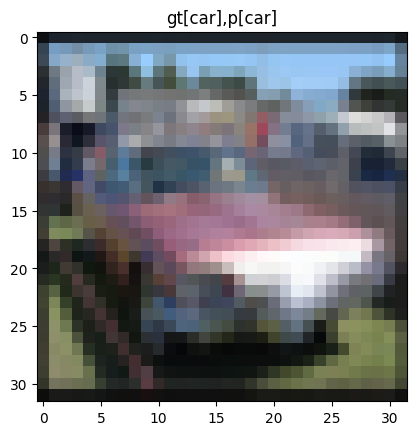

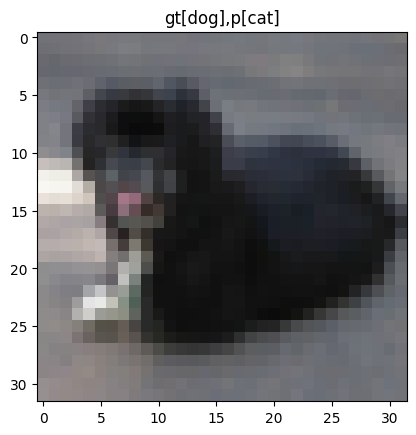

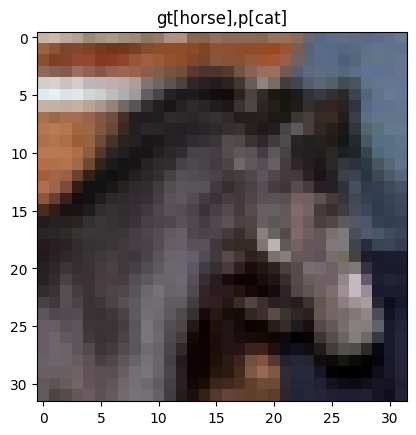

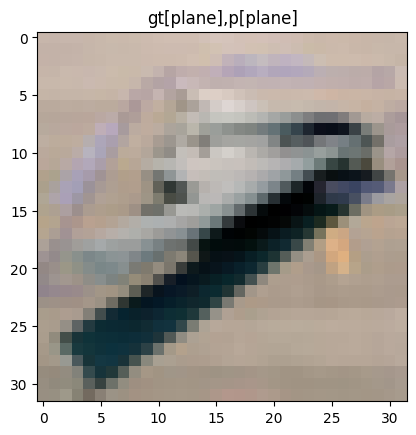

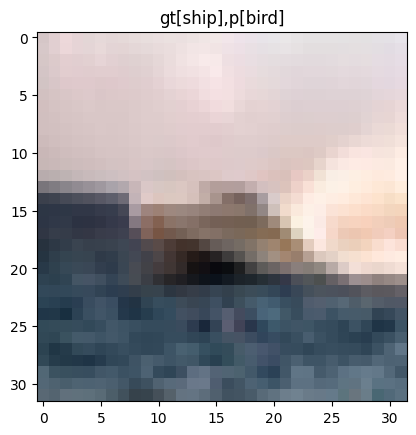

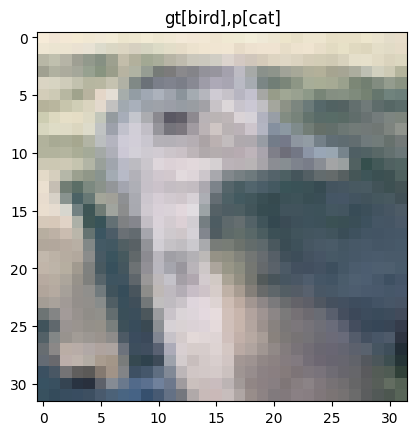

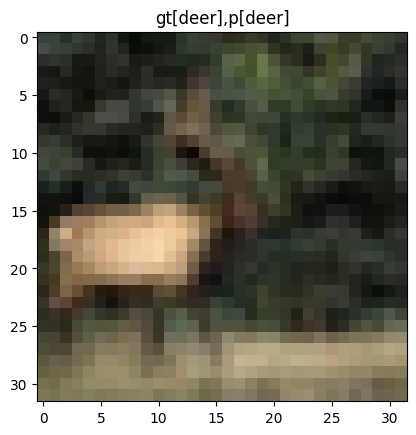

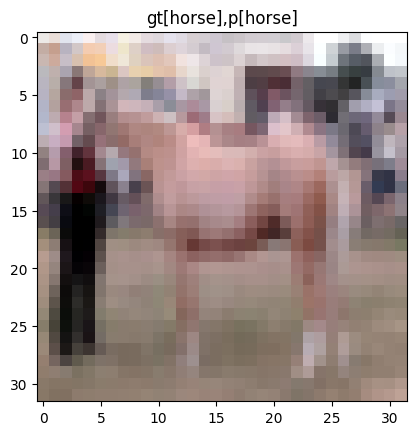

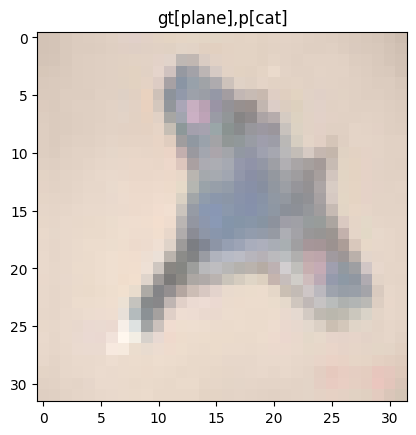

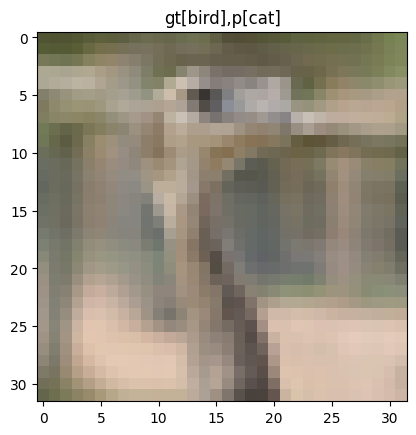

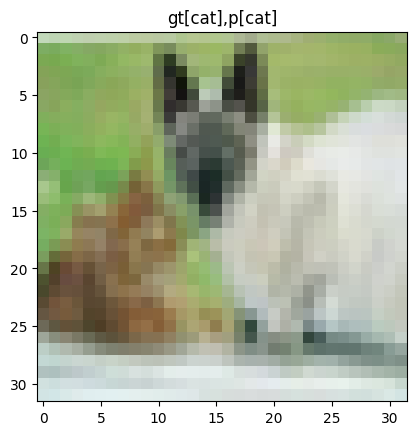

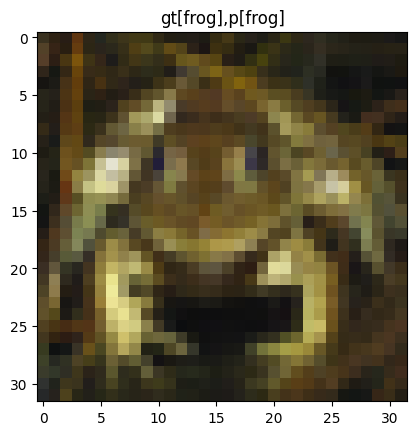

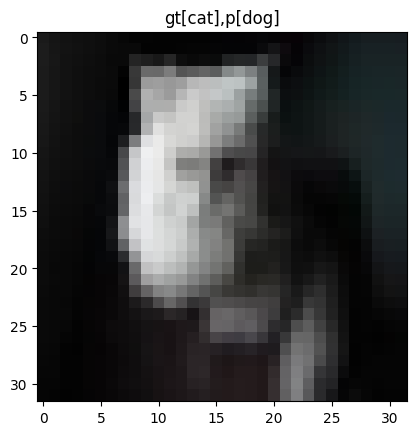

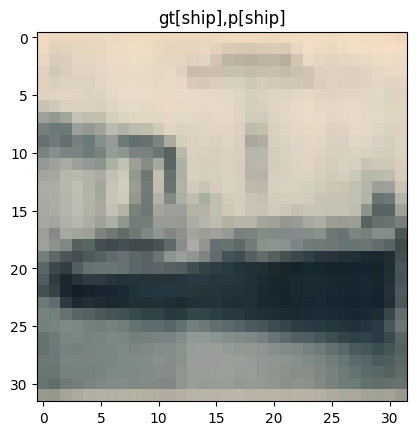

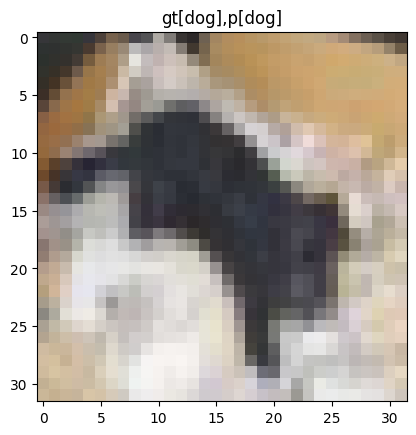

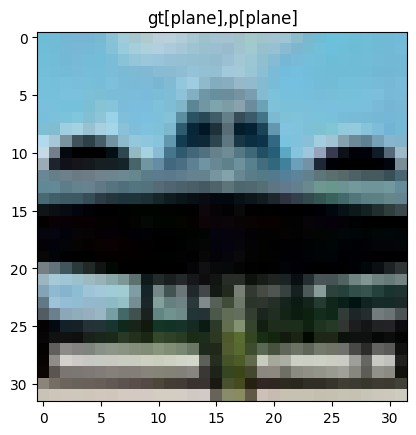

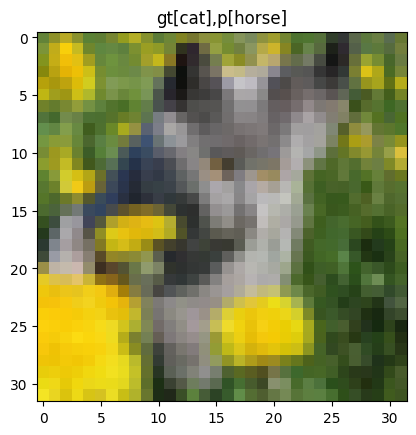

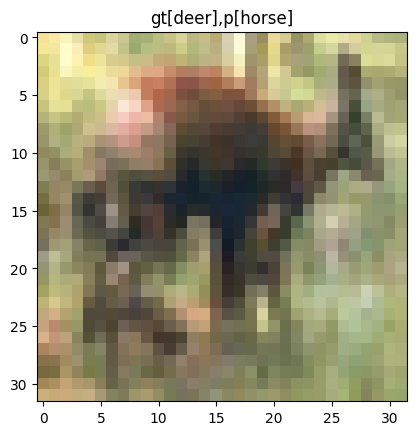

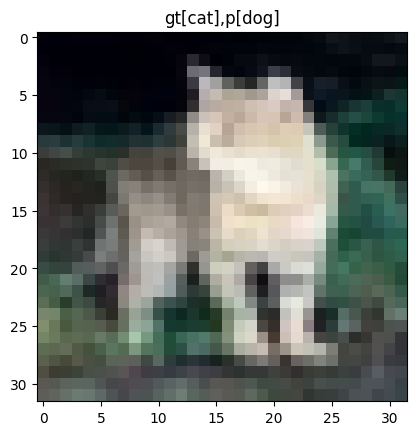

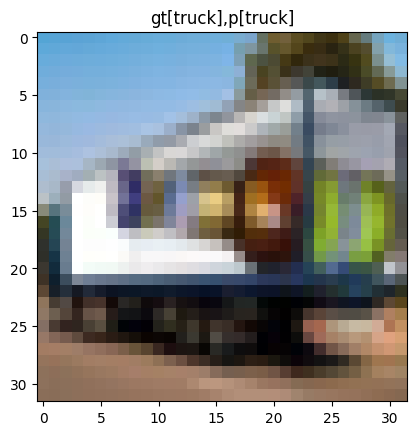

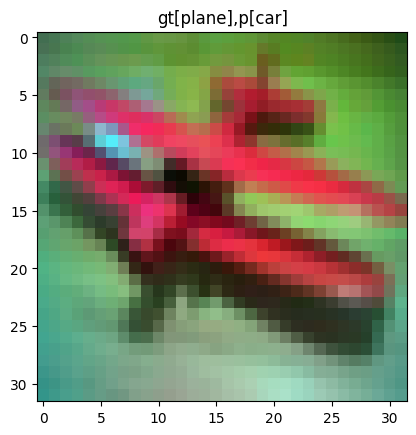

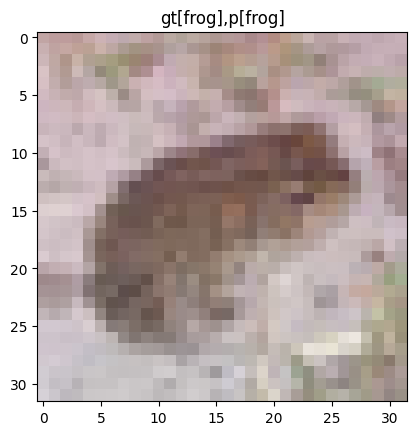

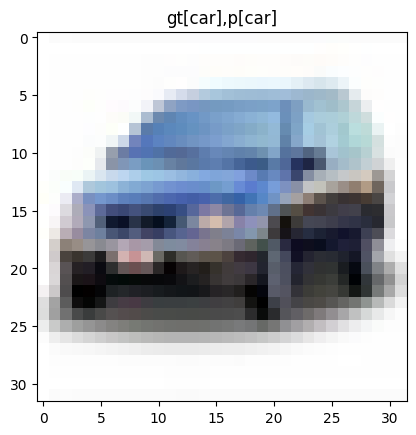

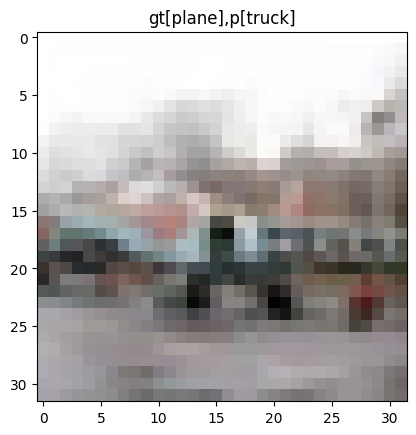

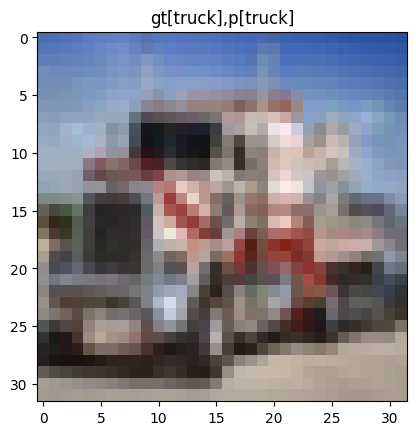

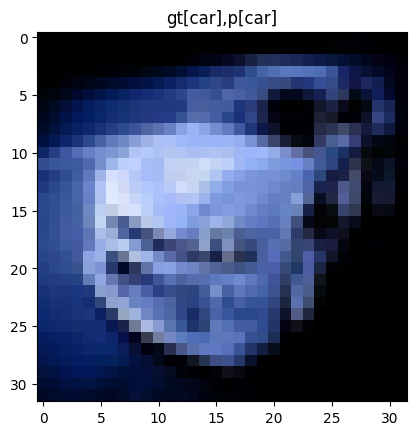

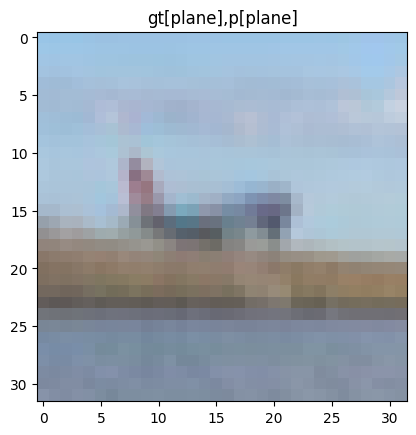

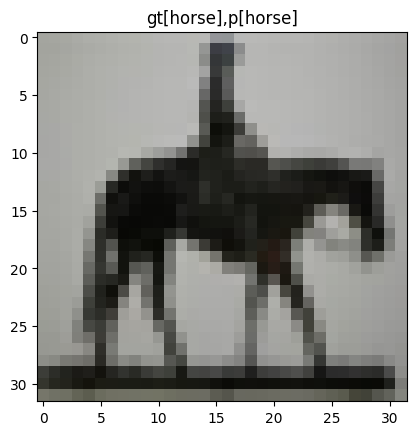

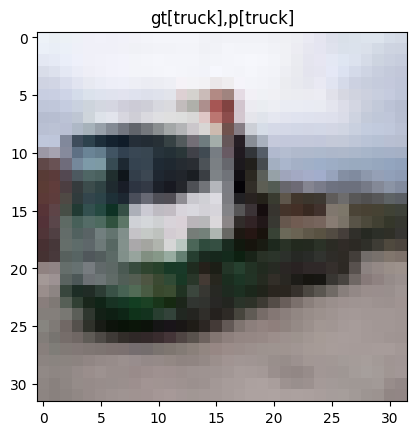

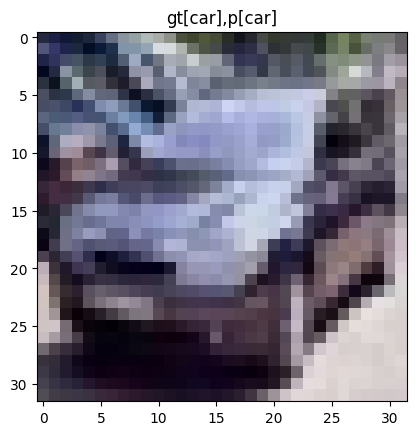

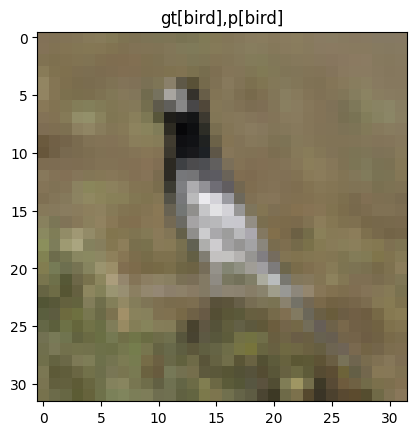

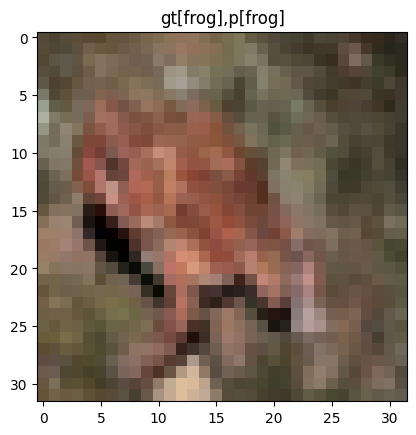

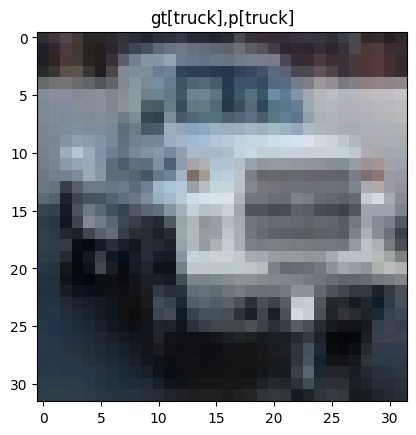

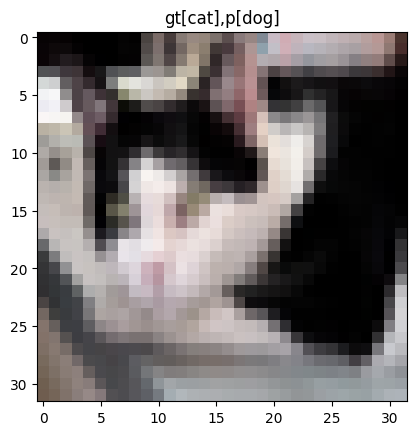

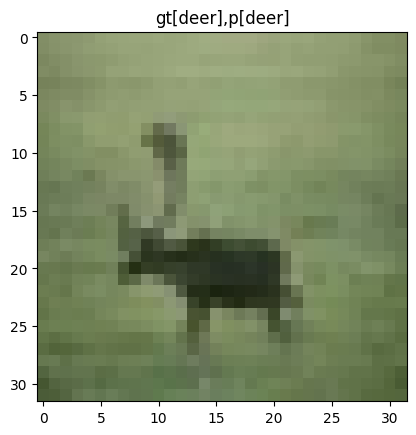

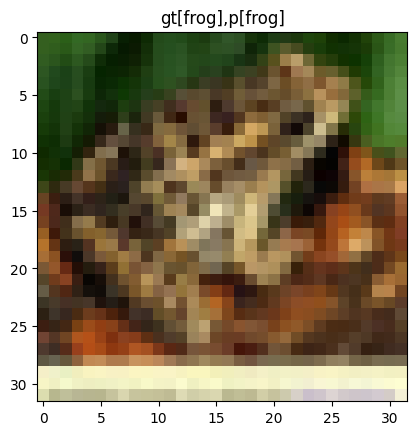

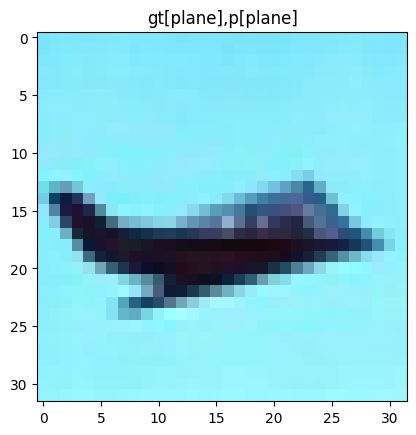

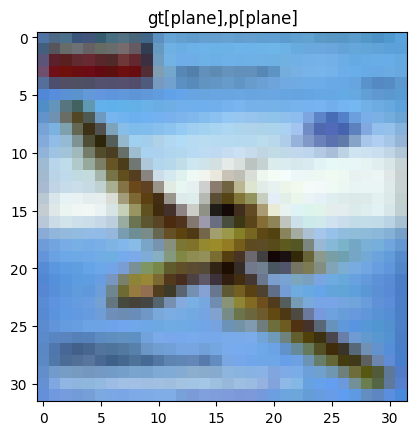

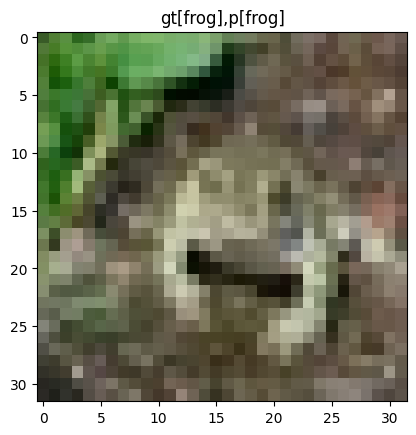

In [34]:
display_torch_result(images, labels, predicts)